In [1]:
import numpy as np
import gym
from gym import spaces
from collections import deque, namedtuple
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
import chess
import random

In [17]:
class ChessEnv(gym.Env):
    def __init__(self):
        super(ChessEnv, self).__init__()
        self.board = chess.Board()
        # The action space: number of possible legal moves
        self.action_space = spaces.Discrete(4672)  # UCI move representation (a reasonable upper bound for moves)
        
        # Observation space: an 8x8x12 board representation (binary encoding of pieces)
        self.observation_space = spaces.Box(low=0, high=1, shape=(8, 8, 12), dtype=np.int8)
        self.move_count = 0
        
    def reset(self, agent_color=chess.WHITE):
        self.agent_color = agent_color
        self.board.reset()
        self.move_count = 0
        self.prev_eval = self._evaluate_board()  # Initial evaluation
        self.last_reward = 0.0
        self.reward = 0
        return self._get_obs()

    def step(self, action):
        move = self._action_to_move(action)
        self.board.push(move)
        self.move_count += 1
        done = self.board.is_game_over()
    
        # Update the reward based on the new move
        current_eval = self._evaluate_board()
        
        # Calculate the reward incrementally
        if self.board.turn == self.agent_color or done:
            self.reward += current_eval - self.prev_eval
            self.prev_eval = current_eval
            self.last_reward = self.reward  # Update last reward with incremental change
        else:
            # Agent just moved, keep the last reward
            reward = self.last_reward
        # Inside step()
        if done:
            result = self.board.result()
            if result == "1-0":
                self.reward += 100 if self.agent_color == chess.WHITE else -100
            elif result == "0-1":
                self.reward += -100 if self.agent_color == chess.WHITE else 100
            else:
                self.reward = 0  
        
        return self._get_obs(), round(self.reward, 4), done, {}




    def _get_obs(self):
        """ Converts the board state to an observation (8x8x12 array) """
        obs = np.zeros((8, 8, 12), dtype=np.int8)

        # Encode each piece type on the board
        for i in range(8):
            for j in range(8):
                piece = self.board.piece_at(i * 8 + j)
                if piece:
                    piece_type = piece.piece_type
                    color = piece.color
                    channel = (piece_type - 1) if color else (piece_type + 5)
                    obs[i, j, channel] = 1

        return obs

    def _action_to_move(self, action):
        """ Converts the action (an integer) into a UCI move """
        move = list(self.board.legal_moves)[action]
        return move

    def _evaluate_board(self):
        reward = self._get_material_score()  # White perspective
        if self.board.is_check():
            reward += 0.5
        reward -= 0.1 * (self.move_count-(1-x.agent_color))
        if self.move_count == 0: reward = 0
    
        # Flip evaluation if agent is black (so agent always wants to maximize reward)
        return reward if self.agent_color == chess.WHITE else -reward


    def render(self, mode='human'):
        """ Renders the current board state (in a human-readable format) """
        print(self.board)
    def _get_material_score(self):
        """Calculates material balance from White's perspective"""
        piece_values = {
            chess.PAWN: 1,
            chess.KNIGHT: 3,
            chess.BISHOP: 3,
            chess.ROOK: 5,
            chess.QUEEN: 9
        }
    
        score = 0
        for square in chess.SQUARES:
            piece = self.board.piece_at(square)
            if piece:
                value = piece_values.get(piece.piece_type, 0)
                score += value if piece.color == chess.WHITE else -value
    
        return score

In [23]:
x = ChessEnv()
n = 0
m = []
done = False
x.reset(chess.WHITE)
i=0
while not done:
    legal_moves = list(x.board.legal_moves)
    action = random.randint(0, len(legal_moves) - 1)
    obs, reward, done, _ = x.step(action)
    if i%2 == 0:
        print("white's turn")
    else:
        print("black's turn")
    print("Reward:", reward)
    print("===")
    i+=1

white's turn
Reward: 0
===
black's turn
Reward: -0.2
===
white's turn
Reward: -0.2
===
black's turn
Reward: -0.4
===
white's turn
Reward: -0.4
===
black's turn
Reward: -0.6
===
white's turn
Reward: -0.6
===
black's turn
Reward: -0.8
===
white's turn
Reward: -0.8
===
black's turn
Reward: -1.0
===
white's turn
Reward: -1.0
===
black's turn
Reward: -1.2
===
white's turn
Reward: -1.2
===
black's turn
Reward: -1.4
===
white's turn
Reward: -1.4
===
black's turn
Reward: -1.6
===
white's turn
Reward: -1.6
===
black's turn
Reward: -1.8
===
white's turn
Reward: -1.8
===
black's turn
Reward: -2.0
===
white's turn
Reward: -2.0
===
black's turn
Reward: -1.7
===
white's turn
Reward: -1.7
===
black's turn
Reward: -2.4
===
white's turn
Reward: -2.4
===
black's turn
Reward: -2.6
===
white's turn
Reward: -2.6
===
black's turn
Reward: -2.8
===
white's turn
Reward: -2.8
===
black's turn
Reward: -3.0
===
white's turn
Reward: -3.0
===
black's turn
Reward: -3.2
===
white's turn
Reward: -3.2
===
black's turn


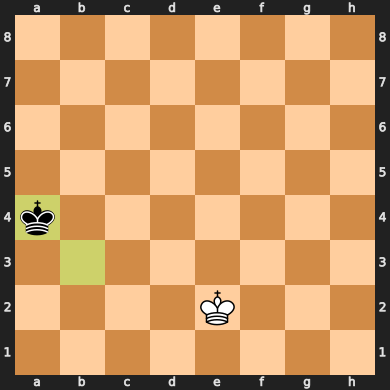

In [24]:
x.board